In [289]:
import os
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

np.set_printoptions(precision=4, suppress=True, linewidth=120)

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator

from pandas.io.json import json_normalize
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#sns.set_context("paper", font_scale=1.3)
#sns.set_style('white')

import datetime
from dateutil.tz import tzutc
#https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [290]:
print("This notebook was created using version 1.18.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.18.0 of the Azure ML SDK
You are currently using version 1.18.0 of the Azure ML SDK


In [291]:
%run ./helper.ipynb

In [292]:
#read input files
time_column_name = 'End of Month'
time_column_name1 = 'Snapshot Date Short'
talenthist = pd.read_csv("TalentHistory.csv", parse_dates=[time_column_name])
pipehist = pd.read_csv("PipelineHistory.csv", parse_dates=[time_column_name,time_column_name1])
revhist = pd.read_csv("RevenueHistory.csv", parse_dates=[time_column_name])
opphist = pd.read_csv("OppHistory.csv", parse_dates=[time_column_name])
projhist = pd.read_csv("ProjectHistory.csv", parse_dates=[time_column_name])
time_column_name2 = 'Latest Snapshot Date Short'
pipetrend = pd.read_csv("PipelineTrend.csv", parse_dates=[time_column_name2])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

,End of Month,Contrib Fin Entity ID,Headcount,Headcount Contingent
290,2021-11-30,CHN,28.00,4.00
291,2021-11-30,DEU,25.00,1.00
292,2021-11-30,GBR,42.00,4.00
293,2021-11-30,JPN,33.00,nan
294,2021-11-30,USA,406.55,13.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Fin Entity ID,Pipeline
6752,2020-12-01,0,2021-10-31,10,GBR,303375.00
6753,2020-12-01,0,2021-10-31,10,USA,286395.07
6754,2020-12-01,0,2021-11-30,11,DEU,48492.36
6755,2020-12-01,0,2021-11-30,11,GBR,28892.86
6756,2020-12-01,0,2021-11-30,11,USA,135717.72


,End of Month,Managing Fin Entity ID,Revenue
230,2020-11-30,USA,1122998.33
231,2020-12-31,USA,557736.30
232,2021-01-31,USA,1443196.00
233,2021-02-28,USA,1296579.00
234,2021-03-31,USA,1066371.00


,End of Month,Managing Fin Entity ID,Current Opp. Period Value
138,2020-11-30,DEU,1560436.80
139,2020-11-30,GBR,514000.00
140,2020-11-30,JPN,997500.00
141,2020-11-30,USA,9148002.00
142,2020-12-31,USA,50000.00


,End of Month,Managing Fin Entity ID,Conversions
191,2020-11-30,DEU,97350.00
192,2020-11-30,GBR,703369.25
193,2020-11-30,JPN,550569.49
194,2020-11-30,USA,7312301.00
195,2020-12-31,USA,785000.00


,Latest Snapshot Date Short,Relative Snapshot Month Offset,Contrib Fin Entity ID,Pipeline Trend
145,2020-12-01,0,CHN,2037994.00
146,2020-12-01,0,DEU,1705216.89
147,2020-12-01,0,GBR,3121719.67
148,2020-12-01,0,JPN,1614189.76
149,2020-12-01,0,USA,26591116.78


In [293]:
#download SP500 closing prices
#if you get an error after executing the code, try adding below. 
#!pip install pandas-datareader

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today
#pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
#SP500 = web.DataReader(['sp500'], 'fred', start, end)
#display(SP500.head())

import pandas_datareader as pdr

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE']+ pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()
#SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
#SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)
SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print("\n SP500: \n")
display(get_df_name(SP500))
print("\n DF Info: \n")
display(SP500.info(verbose=True))
print("\n SP500 Describe: \n")
display(SP500.describe(include='all').transpose().head())
print("\n SP500 Head: \n")
display(SP500.head())
print("\n SP500 Tail: \n")
display(SP500.tail())
SP500['Monthly_Return'].plot(title='S&P 500 monthly returns')


 SP500: 



'SP500'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 58
Data columns (total 2 columns):
End_of_Month    59 non-null datetime64[ns]
sp500           59 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


None


 SP500 Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,59,59,2017-11-30,1,2016-01-31,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,59.000000,NaN,NaT,NaN,NaT,NaT,2674.847627,404.397897,1932.230000,2373.920000,2705.270000,2943.795000,3621.630000



 SP500 Head: 



,End_of_Month,sp500
0,2016-01-31,1940.240000
1,2016-02-29,1932.230000
2,2016-03-31,2059.740000
3,2016-04-30,2065.300000
4,2016-05-31,2096.960000



 SP500 Tail: 



,End_of_Month,sp500
54,2020-07-31,3271.120000
55,2020-08-31,3500.310000
56,2020-09-30,3363.000000
57,2020-10-31,3269.960000
58,2020-11-30,3621.630000


KeyError: 'Monthly_Return'

In [ ]:
#create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'revenue-time-forecast'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "cibimldev01"

compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
print('Found existing cluster, use it.')

In [ ]:
#Rename Studio, filter studio and prep data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#exclude_studio = ["Regional Bay Area", "Regional ChiCamNY", "Palo Alto", "Singapore", "Unknown", "North America"]

#display(exclude_studio)
talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = talenthist1.columns.astype(str).str.replace("Contrib ", "")
pipehist1.columns = pipehist1.columns.astype(str).str.replace("Contrib ", "")
pipetrend1.columns = pipetrend1.columns.astype(str).str.replace("Contrib ", "")
opphist1.columns = opphist1.columns.astype(str).str.replace("Managing ", "")
projhist1.columns = projhist1.columns.astype(str).str.replace("Managing ", "")
revhist1.columns = revhist1.columns.astype(str).str.replace("Managing ", "")
#talenthist1 = talenthist.rename(columns={"Contrib Studio Name": "Studio"})
#pipehist1 = pipehist.rename(columns={"Contrib Studio Name": "Studio"})

#revhist1 = revhist.rename(columns={"Managing Studio Name": "Studio"})
pipetrend1 = pipetrend1.rename(columns={"Latest Snapshot Date Short": "End of Month",
                                       #"Contrib Studio Name": "Studio", 
                                       "Relative Snapshot Month Offset": "Relative Month Offset"})
#opphist1 = opphist.rename(columns={"Managing Studio Name": "Studio"})
#projhist1 = projhist.rename(columns={"Managing Studio Name": "Studio"})
#revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)
display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
display(pipetrend1)
show_stats(pipehist1)

#revhist1 = revhist1.query('Fin_Entity_ID not in ["SGP",0]').copy()
pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] + pd.offsets.MonthEnd(0) 
projhist1['End_of_Month'] = projhist1['End_of_Month'] + pd.offsets.MonthEnd(0) 

#Sort
pipehist1.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
revhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
talenthist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
pipetrend1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
opphist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
projhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)

display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

In [294]:
pipetrend1

,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-29,CHN,3155949
1,2018-07-31,-29,DEU,3192363
2,2018-07-31,-29,GBR,5859349
3,2018-07-31,-29,JPN,5835788
4,2018-07-31,-29,USA,119235644
...,...,...,...,...
145,2020-12-31,0,CHN,2037994
146,2020-12-31,0,DEU,1705216
147,2020-12-31,0,GBR,3121719
148,2020-12-31,0,JPN,1614189


In [295]:
revhist1

,End_of_Month,Fin_Entity_ID,Revenue
0,2017-01-31,CHN,639967
1,2017-01-31,DEU,515289
2,2017-01-31,GBR,640653
3,2017-01-31,JPN,329393
4,2017-01-31,USA,10671035
...,...,...,...
230,2020-11-30,USA,1122998
231,2020-12-31,USA,557736
232,2021-01-31,USA,1443196
233,2021-02-28,USA,1296579


In [296]:
print("\n revhist1: \n")
#revhist1.to_csv("revhist1.csv", index=False)
#show_stats(revhist1)
#display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
#pivot
revhist_pivot = revhist1.pivot_table(index='End_of_Month',#columns = ['Fin_Entity_ID'], 
                                     values='Revenue', 
                                     #aggfunc=['sum','count'], 
                                     margins=False)
#revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})
revhist_pivot = revhist_pivot.reset_index(level=revhist_pivot.index.names)
#revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
#revhist_pivot.index.name = 'Date'
revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail()


 revhist1: 



,End_of_Month,Revenue
46,2020-11-30,1122998.000000
47,2020-12-31,557736.000000
48,2021-01-31,1443196.000000
49,2021-02-28,1296579.000000
50,2021-03-31,1066371.000000


In [297]:
# Cross join to get all unquie values of End_of_Month and Studio
d = pd.date_range(start_date,end_date,freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])
#eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep="last").sort_values(by=['End_of_Month']).reset_index(drop=True)
studio = pd.DataFrame(talenthist1['Fin_Entity_ID'].unique(), columns=['Fin_Entity_ID'])
eom['key'] = 0
studio['key'] = 0
eom_studio = pd.merge(eom, studio, on=['key'])
eom_studio = eom_studio.replace(np.nan, "Unknown", regex=True)
eom_studio.drop(columns=['key'], axis=1, inplace = True)
print("\n eom_studio: \n")
display(eom_studio.info(verbose=True))
eom_studio


 eom_studio: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 2 columns):
End_of_Month     295 non-null datetime64[ns]
Fin_Entity_ID    295 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 6.9+ KB


None

,End_of_Month,Fin_Entity_ID
0,2017-01-31,CHN
1,2017-01-31,DEU
2,2017-01-31,GBR
3,2017-01-31,JPN
4,2017-01-31,USA
...,...,...
290,2021-11-30,CHN
291,2021-11-30,DEU
292,2021-11-30,GBR
293,2021-11-30,JPN


In [298]:
#Merge eom_studio with Revenue, Talent, Opportunity, Project
from functools import reduce
nan_value = 0
merge_dfs = [eom_studio, revhist1, talenthist1, opphist1, projhist1, pipetrend1]

merge_df = reduce(lambda left,right: pd.merge(left, right, 
                                              how='left',
                                              on=['End_of_Month','Fin_Entity_ID']), 
                  merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
merge_df['Total_Headcount'] = merge_df['Headcount'] + merge_df['Headcount_Contingent']
merge_df.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
print("\n merge_df: \n")
merge_df.to_csv("merge_df.csv", index=False)
#show_stats(merge_df)
merge_df.query('Fin_Entity_ID==@entity_debug')


 merge_df: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
2,2017-01-31,GBR,640653,27,3,0,912449,-47,0,30
7,2017-02-28,GBR,686520,28,3,0,293644,-46,0,31
12,2017-03-31,GBR,695914,28,1,0,484583,-45,0,29
17,2017-04-30,GBR,620690,28,1,0,0,-44,0,29
22,2017-05-31,GBR,480997,29,1,0,255102,-43,0,30
27,2017-06-30,GBR,613119,30,1,0,958208,-42,0,31
32,2017-07-31,GBR,924330,31,1,0,4920,-41,0,32
37,2017-08-31,GBR,652908,30,1,0,1677150,-40,0,31
42,2017-09-30,GBR,906711,30,1,0,322465,-39,0,31
47,2017-10-31,GBR,813818,29,1,0,367121,-38,0,30


In [299]:
#Merge with SP500
eom1 = pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])
#sp500_df = sp500_df.ffill(axis = 0)
#sp500_df = sp500_df.sort_values(by=['End_of_Month']).reset_index(drop=True)
display(sp500_df.tail())
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'])
coerce_df_columns_to_numeric(merge_df1)
merge_df1.drop(columns=['Headcount','Headcount_Contingent'], axis=1, inplace = True) #'Monthly_Return','sp500_1M_Previous'
merge_df1 = merge_df1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
merge_df1.to_csv("merge_df1.csv", index=False)
show_stats(merge_df1)

,End_of_Month,sp500
54,2021-07-31,nan
55,2021-08-31,nan
56,2021-09-30,nan
57,2021-10-31,nan
58,2021-11-30,nan



 DF Name: 



'merge_df1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 9 columns):
End_of_Month                 295 non-null datetime64[ns]
Fin_Entity_ID                295 non-null object
Revenue                      295 non-null int64
Current_Opp._Period_Value    295 non-null int64
Conversions                  295 non-null int64
Relative_Month_Offset        295 non-null int64
Pipeline_Trend               295 non-null int64
Total_Headcount              295 non-null int64
sp500                        235 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 20.9+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,295,59,2017-11-30 00:00:00,5,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,295,5,GBR,59,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,295.000000,NaN,NaN,NaN,NaT,NaT,2263840.403390,4006370.097060,0.000000,399981.000000,686520.000000,993530.000000,14401673.000000
Current_Opp._Period_Value,295.000000,NaN,NaN,NaN,NaT,NaT,4091746.837288,10940184.082111,0.000000,0.000000,0.000000,2160644.000000,114217949.000000
Conversions,295.000000,NaN,NaN,NaN,NaT,NaT,1946153.708475,4026453.821150,0.000000,0.000000,271176.000000,1197023.000000,22379515.000000



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.870000
1,2017-01-31,DEU,515289,0,9959,-47,0,25,2278.870000
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.870000
3,2017-01-31,JPN,329393,0,0,-47,0,18,2278.870000
4,2017-01-31,USA,10671035,0,12148741,-47,0,413,2278.870000



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
290,2021-11-30,CHN,0,0,0,11,0,32,nan
291,2021-11-30,DEU,0,0,0,11,0,26,nan
292,2021-11-30,GBR,0,0,0,11,0,46,nan
293,2021-11-30,JPN,0,0,0,11,0,33,nan
294,2021-11-30,USA,0,0,0,11,0,419,nan



 Entity Sum: 



,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,CHN,33541483,62534126,32085031,-1062,251391177,1723,132546.070000
1,DEU,27676819,61537484,22175585,-1062,220879033,1639,132546.070000
2,GBR,43715091,78564737,18725874,-1062,386783987,2394,132546.070000
3,JPN,29740004,63710475,23290937,-1062,253724511,1632,132546.070000
4,USA,533159522,940718495,477837917,-1062,4256497673,26116,132546.070000



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,CHN,59,59,59,59,59,59,59,47
1,DEU,59,59,59,59,59,59,59,47
2,GBR,59,59,59,59,59,59,59,47
3,JPN,59,59,59,59,59,59,59,47
4,USA,59,59,59,59,59,59,59,47



 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,12796337,0,13505689,-235,0,512,11394.350000
1,2017-02-28,12476757,0,8659142,-230,0,511,11818.200000
2,2017-03-31,14191127,0,12745280,-225,0,513,11813.600000
3,2017-04-30,12449452,0,10701239,-220,0,508,11921.000000
4,2017-05-31,13669410,0,6457961,-215,0,514,12059.000000



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5


In [300]:
#Calculate pipeline month offset for corresponding snapshot dates
rolling_pipeline_period = 12
pipehist_long = pipehist1.copy()
pipehist_long["Relative_Offset"] = (pipehist_long['Relative_Month_Offset'] - pipehist_long['Relative_Snapshot_Month_Offset'])
pipehist_long = pipehist_long \
                .query('Relative_Offset >= -@rolling_pipeline_period and ' + 
                        'Relative_Offset < @rolling_pipeline_period and ' +
                        'Snapshot_Date_Short <= @end_date') 
#pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].astype(str).str.zfill(2) + 'M Pipeline'
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace('0','+')
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace('++M Pipeline','+0M Pipeline')
#pipehist_long["Relative_Offset"] = "Relative" + pipehist_long["Relative_Offset"].str.replace("0-","-0")
pipehist_long.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n pipehist_long: \n")
pipehist_long.to_csv("pipehist_long.csv", index=False)
print(pipehist_long.query('Fin_Entity_ID==@entity_debug'))
pipehist_long


 pipehist_long: 

     Snapshot_Date_Short  Relative_Snapshot_Month_Offset End_of_Month  Relative_Month_Offset Fin_Entity_ID  Pipeline  Relative_Offset
32   2018-07-31          -29                             2017-07-31   -41                     GBR           924330   -12             
37   2018-07-31          -29                             2017-08-31   -40                     GBR           652908   -11             
42   2018-07-31          -29                             2017-09-30   -39                     GBR           906711   -10             
47   2018-07-31          -29                             2017-10-31   -38                     GBR           813818   -9              
52   2018-07-31          -29                             2017-11-30   -37                     GBR           853997   -8              
...         ...           ..                                    ...    ..                     ...              ...   ..              
6740 2020-12-31           0                

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset
30,2018-07-31,-29,2017-07-31,-41,CHN,581189,-12
31,2018-07-31,-29,2017-07-31,-41,DEU,403545,-12
32,2018-07-31,-29,2017-07-31,-41,GBR,924330,-12
33,2018-07-31,-29,2017-07-31,-41,JPN,405259,-12
34,2018-07-31,-29,2017-07-31,-41,USA,9498045,-12
...,...,...,...,...,...,...,...
6752,2020-12-31,0,2021-10-31,10,GBR,303375,10
6753,2020-12-31,0,2021-10-31,10,USA,286395,10
6754,2020-12-31,0,2021-11-30,11,DEU,48492,11
6755,2020-12-31,0,2021-11-30,11,GBR,28892,11


In [301]:
#Convert pipe history from long to wide to match month end grain

pipehist_wide = pipehist_long \
                .pivot_table(index=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'], 
                                    columns='Relative_Offset', 
                                    values='Pipeline', 
                                    aggfunc=np.sum,
                                    margins=False)
pipehist_wide = pipehist_wide.reset_index(level=pipehist_wide.index.names).reset_index(drop=True)
cols = list(pipehist_wide.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist_wide)
pipehist_wide['End_of_Month'] = pd.to_datetime(pipehist_wide['End_of_Month'])
pipehist_wide = pipehist_wide.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n pipehist_wide: \n")
print(pipehist_wide.info())
print(pipehist_wide.query('Fin_Entity_ID==@entity_debug'))


 pipehist_wide: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 27 columns):
End_of_Month             259 non-null datetime64[ns]
Relative_Month_Offset    259 non-null int64
Fin_Entity_ID            259 non-null object
-12                      259 non-null int64
-11                      259 non-null int64
-10                      259 non-null int64
-9                       259 non-null int64
-8                       259 non-null int64
-7                       259 non-null int64
-6                       259 non-null int64
-5                       259 non-null int64
-4                       259 non-null int64
-3                       259 non-null int64
-2                       259 non-null int64
-1                       259 non-null int64
0                        259 non-null int64
1                        259 non-null int64
2                        259 non-null int64
3                        259 non-null int64
4                        259 n

In [302]:
# Merge merge_df with Pipeline Long History 
#pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
merge_final = pd.merge(merge_df1, pipehist_wide, how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
#revpipe_final['End_of_Month'] = pd.to_datetime(revpipe_final['End_of_Month'])
#merge_final['Snapshot_Date_Short'] = pd.to_datetime(merge_final['Snapshot_Date_Short'])
#revpipe_final['Relative_Month_Offset'] = round((revpipe_final['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
coerce_df_columns_to_numeric(merge_final)
# Filter for only next 11 months rows w.r.t. to snapshot date
#revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
merge_final = merge_final.replace(np.nan, 0, regex=True)
merge_final = merge_final.sort_values(by=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID']).reset_index(drop=True)
merge_final.rename(columns = {-12: '-12M Pipeline', -11: '-11M Pipeline', -10: '-10M Pipeline', -9: '-9M Pipeline', -8: '-8M Pipeline', -7: '-7M Pipeline',\
                              -6: '-6M Pipeline', -5: '-5M Pipeline', -4: '-4M Pipeline', -3: '-3M Pipeline', -2: '-2M Pipeline', -1: '-1M Pipeline',\
                             0: '0M Pipeline', 1: '1M Pipeline', 2: '2M Pipeline', 3: '3M Pipeline', 4: '4M Pipeline', 5: '5M Pipeline',\
                             6: '6M Pipeline', 7: '7M Pipeline', 8: '8M Pipeline', 9: '9M Pipeline', 10: '10M Pipeline', 11: '11M Pipeline'}, inplace = True)
print("\n revpipe_final1: \n")
merge_final.to_csv("merge_final.csv", index=False)
show_stats(merge_final)
merge_final.query('Fin_Entity_ID==@entity_debug')


 revpipe_final1: 


 DF Name: 



'merge_final'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 33 columns):
End_of_Month                 295 non-null datetime64[ns]
Fin_Entity_ID                295 non-null object
Revenue                      295 non-null int64
Current_Opp._Period_Value    295 non-null int64
Conversions                  295 non-null int64
Relative_Month_Offset        295 non-null int64
Pipeline_Trend               295 non-null int64
Total_Headcount              295 non-null int64
sp500                        295 non-null float64
-12M Pipeline                295 non-null int64
-11M Pipeline                295 non-null int64
-10M Pipeline                295 non-null int64
-9M Pipeline                 295 non-null int64
-8M Pipeline                 295 non-null int64
-7M Pipeline                 295 non-null int64
-6M Pipeline                 295 non-null int64
-5M Pipeline                 295 non-null int64
-4M Pipeline                 295 non-null int64
-3M Pi

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,295,59,2017-11-30 00:00:00,5,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,295,5,GBR,59,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,295.000000,NaN,NaN,NaN,NaT,NaT,2263840.403390,4006370.097060,0.000000,399981.000000,686520.000000,993530.000000,14401673.000000
Current_Opp._Period_Value,295.000000,NaN,NaN,NaN,NaT,NaT,4091746.837288,10940184.082111,0.000000,0.000000,0.000000,2160644.000000,114217949.000000
Conversions,295.000000,NaN,NaN,NaN,NaT,NaT,1946153.708475,4026453.821150,0.000000,0.000000,271176.000000,1197023.000000,22379515.000000



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-31,DEU,515289,0,9959,-47,0,25,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-31,JPN,329393,0,0,-47,0,18,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-31,USA,10671035,0,12148741,-47,0,413,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
290,2021-11-30,CHN,0,0,0,11,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
291,2021-11-30,DEU,0,0,0,11,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48492
292,2021-11-30,GBR,0,0,0,11,0,46,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28892
293,2021-11-30,JPN,0,0,0,11,0,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
294,2021-11-30,USA,0,0,0,11,0,419,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,135717



 Entity Sum: 



,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,CHN,33541483,62534126,32085031,-1062,251391177,1723,132546.070000,23077400,23348740,23055326,23251581,23013931,22697564,22678715,22667698,22927643,22613540,22332828,22178284,21841106,23542394,22249178,15848384,11482726,8553600,6738022,4952069,3433964,2196564,1503966,700077
1,DEU,27676819,61537484,22175585,-1062,220879033,1639,132546.070000,18520873,18836917,19166367,19480074,19301957,19067289,19070758,18773582,18847954,18458242,18354120,18431634,18167321,20310965,19547297,15077995,10152598,7425571,6075890,4655600,3321863,2282127,1825500,1509302
2,GBR,43715091,78564737,18725874,-1062,386783987,2394,132546.070000,29500549,29724065,29946803,30286304,30473932,30646499,30975926,31481759,31882273,32074478,32355631,32635328,31713433,32771182,33213647,28935129,22358552,16519113,12823258,9607482,7051524,4760706,3189499,2242886
3,JPN,29740004,63710475,23290937,-1062,253724511,1632,132546.070000,20092627,20409938,20810969,21273056,21467354,21585872,21697548,21803565,21974139,22308397,22547955,22739462,22690452,24519045,21888123,15854557,9446989,5999988,4154229,2644269,1543445,943587,608424,445348
4,USA,533159522,940718495,477837917,-1062,4256497673,26116,132546.070000,353567853,356787142,357038321,358533767,356788803,355137655,356231422,356234845,355364532,352169580,352869350,350480322,333922285,393145698,377841871,308904388,220320434,147234563,103979266,73256742,49113059,33985565,22673024,14502021



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,CHN,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
1,DEU,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
2,GBR,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
3,JPN,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
4,USA,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59



 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,12796337,0,13505689,-235,0,512,11394.350000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-02-28,12476757,0,8659142,-230,0,511,11818.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-03-31,14191127,0,12745280,-225,0,513,11813.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-04-30,12449452,0,10701239,-220,0,508,11921.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-05-31,13669410,0,6457961,-215,0,514,12059.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017-02-28,GBR,686520,0,293644,-46,0,31,2363.640000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,2017-03-31,GBR,695914,0,484583,-45,0,29,2362.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,2017-04-30,GBR,620690,0,0,-44,0,29,2384.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,2017-05-31,GBR,480997,0,255102,-43,0,30,2411.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,2017-06-30,GBR,613119,0,958208,-42,0,31,2423.410000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2017-07-31,GBR,924330,0,4920,-41,0,32,2470.300000,924330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,2017-08-31,GBR,652908,0,1677150,-40,0,31,2471.650000,652908,652908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,2017-09-30,GBR,906711,0,322465,-39,0,31,2519.360000,906711,906711,906711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47,2017-10-31,GBR,813818,0,367121,-38,0,30,2575.260000,813818,813818,813818,813818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [303]:
#To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:
target_column_name = 'Revenue'
time_column_name = 'End_of_Month'
time_series_id_column_names = ['Fin_Entity_ID']
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final
#df = merge_final.drop(columns=['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)
nseries = df.groupby(time_series_id_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 5 individual time-series.


In [304]:
tseries = df.groupby(time_column_name).ngroups
print('Data contains {0} individual End_of_Month.'.format(tseries))

Data contains 59 individual End_of_Month.


In [305]:
# Merge Fin Entity ID to do the revenue forecast at IDEO level first
display(df)
#df_sum = df.pivot_table(index=sort_list,
                       #values=['Revenue', 'Headcount','Headcount_Contingent','Pipeline'],
                       #aggfunc={'Revenue':np.sum,'Headcount':np.sum,'Headcount_Contingent':np.sum},
#                       margins=False)
#merge_final_sum = merge_final_sum.rename(columns={'sum':'Revenue'})
#df_sum = df_sum.reset_index(level=df_sum.index.names)
#3df_sum

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-31,DEU,515289,0,9959,-47,0,25,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-31,JPN,329393,0,0,-47,0,18,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-31,USA,10671035,0,12148741,-47,0,413,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2021-11-30,CHN,0,0,0,11,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
291,2021-11-30,DEU,0,0,0,11,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48492
292,2021-11-30,GBR,0,0,0,11,0,46,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28892
293,2021-11-30,JPN,0,0,0,11,0,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [306]:
#Data Split
#split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series. 
#The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
test_size = .11 #in percentage
n_test_periods =  int(tseries * test_size)
#n_test_periods = rolling_pipeline_period
n_test_periods

6

In [307]:
#Filter final dataframe for current month + forecast horizon of n_test_periods
#merge_final1 = merge_final.copy()#['End_of_Month'] + pd.offsets.MonthEnd(n_test_periods) 
end_date1 = last_eom + pd.offsets.MonthEnd(n_test_periods) #+ pd.offsets.MonthEnd(-2)
print(end_date1)
df1 = df.query('End_of_Month <= @end_date1').sort_values(by=sort_list).reset_index(drop=True)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
df1.info()
df1.query('Fin_Entity_ID==@entity_debug').sort_values(by=sort_list)# 

2021-03-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 33 columns):
End_of_Month                 255 non-null datetime64[ns]
Fin_Entity_ID                255 non-null object
Revenue                      255 non-null int64
Current_Opp._Period_Value    255 non-null int64
Conversions                  255 non-null int64
Relative_Month_Offset        255 non-null int64
Pipeline_Trend               255 non-null int64
Total_Headcount              255 non-null int64
sp500                        255 non-null float64
-12M Pipeline                255 non-null int64
-11M Pipeline                255 non-null int64
-10M Pipeline                255 non-null int64
-9M Pipeline                 255 non-null int64
-8M Pipeline                 255 non-null int64
-7M Pipeline                 255 non-null int64
-6M Pipeline                 255 non-null int64
-5M Pipeline                 255 non-null int64
-4M Pipeline                 255 non-null int64

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017-02-28,GBR,686520,0,293644,-46,0,31,2363.640000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,2017-03-31,GBR,695914,0,484583,-45,0,29,2362.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,2017-04-30,GBR,620690,0,0,-44,0,29,2384.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,2017-05-31,GBR,480997,0,255102,-43,0,30,2411.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,2017-06-30,GBR,613119,0,958208,-42,0,31,2423.410000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2017-07-31,GBR,924330,0,4920,-41,0,32,2470.300000,924330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,2017-08-31,GBR,652908,0,1677150,-40,0,31,2471.650000,652908,652908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,2017-09-30,GBR,906711,0,322465,-39,0,31,2519.360000,906711,906711,906711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47,2017-10-31,GBR,813818,0,367121,-38,0,30,2575.260000,813818,813818,813818,813818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [308]:
train, test = split_full_for_forecasting(df=df1, time_column_name=time_column_name, grain_column_names=time_series_id_column_names,test_split=test_size)
#train, test = split_last_n_by_series_id(df1, n_test_periods)
#test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
#train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(Snapshot_Date_Short < 0)').reset_index(drop=True)
display(train)
display(test)
#df1 = df.copy()
#train = df1.sample(frac=train_size, random_state=0)
#test = df1.drop(train.index)
#train_size = int(df.shape[0] * 0.9)
#train = df[:n_test_periods]
#test = df[n_test_periods:]
train.to_csv(r'./revtime_train.csv', index = None, header=True)
test.to_csv(r'./revtime_test.csv', index = None, header=True)
#train_file_path = 'train.csv'
#test_file_path = 'eval.csv'

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017-02-28,CHN,626792,0,1978131,-46,0,27,2363.640000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2017-03-31,CHN,787987,0,0,-45,0,26,2362.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,2017-04-30,CHN,903022,0,1299894,-44,0,25,2384.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2017-05-31,CHN,719566,0,410633,-43,0,26,2411.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2020-06-30,USA,10858122,21784901,9501417,-6,126521970,447,3100.290000,0,0,0,0,0,0,10858125,10858125,10858125,10858125,10858125,10858125,10830037,13201257,9929776,11906603,9424954,6057715,3658279,2638496,1295631,926419,809113,127796
214,2020-07-31,USA,12328340,16159400,11213216,-5,123012807,442,3271.120000,0,0,0,0,0,0,0,12328339,12328339,12328339,12328339,12328339,12088902,12184984,12418145,8775260,10623043,6908687,4471193,2509358,1991770,521975,598624,363744
219,2020-08-31,USA,10320678,33327484,7371988,-4,134992865,440,3500.310000,0,0,0,0,0,0,0,0,10320681,10320681,10320681,10320681,10432896,12071248,12171993,10612735,6776533,7441146,4931528,3212107,1413711,1221504,392297,495628
224,2020-09-30,USA,8500080,27473750,8118021,-3,94311290,450,3363.000000,0,0,0,0,0,0,0,0,0,8500081,8500081,8500081,8178169,9545902,10901885,9754667,8512563,6198031,6762805,3723652,2326824,1468976,1141987,364152


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
230,2020-11-30,CHN,0,2288135,1264865,-1,10158254,33,3621.630000,0,0,0,0,0,0,0,0,0,0,0,772664,772664,1235091,1123457,643538,465681,219259,119989,76975,80460,405355,254256,191293
235,2020-12-31,CHN,0,0,0,0,2037994,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,644620,644620,643539,818182,580025,382578,188985,58159,12658,0,375000,72873
240,2021-01-31,CHN,0,0,0,1,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,730173,730173,483322,527130,409709,151518,32791,0,0,0,227268
245,2021-02-28,CHN,0,0,0,2,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,635647,635647,336568,479593,419639,160720,86907,0,0,0
250,2021-03-31,CHN,0,0,0,3,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623499,623499,246964,276270,319375,110004,99807,0,0
231,2020-11-30,DEU,0,1560436,97350,-1,8978089,27,3621.630000,0,0,0,0,0,0,0,0,0,0,0,823226,823226,767040,800391,450504,482584,366715,254206,253834,86901,66733,56587,78143
236,2020-12-31,DEU,0,0,0,0,1705216,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,593093,593093,553432,460008,268498,401431,268728,260087,214768,48548,49514,49514
241,2021-01-31,DEU,0,0,0,1,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,507829,507829,418337,341186,90802,226715,91957,87906,64208,0,0
246,2021-02-28,DEU,0,0,0,2,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,582877,582877,399180,299347,86478,191585,41652,28800,55026,0
251,2021-03-31,DEU,0,0,0,3,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,369799,369799,264242,161432,99449,134500,24195,30220,63280


In [309]:
# Summary Stats for Train and Test dataframes
print("Train************************")
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 229
Data columns (total 33 columns):
End_of_Month                 230 non-null datetime64[ns]
Fin_Entity_ID                230 non-null object
Revenue                      230 non-null int64
Current_Opp._Period_Value    230 non-null int64
Conversions                  230 non-null int64
Relative_Month_Offset        230 non-null int64
Pipeline_Trend               230 non-null int64
Total_Headcount              230 non-null int64
sp500                        230 non-null float64
-12M Pipeline                230 non-null int64
-11M Pipeline                230 non-null int64
-10M Pipeline                230 non-null int64
-9M Pipeline                 230 non-null int64
-8M Pipeline                 230 non-null int64
-7M Pipeline                 230 non-null int64
-6M Pipeline                 230 non-null int64
-5M Pipeline                 230 non-null int64
-4M Pipeline                 230 non-

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,230,46,2017-11-30 00:00:00,5,2017-01-31,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,230,5,GBR,46,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,230.000000,NaN,NaN,NaN,NaT,NaT,2879765.386957,4341828.178753,195142.000000,606723.750000,775012.000000,1104218.500000,14401673.000000
Current_Opp._Period_Value,230.000000,NaN,NaN,NaN,NaT,NaT,5184814.104348,12158276.011961,0.000000,0.000000,876448.500000,2912052.000000,114217949.000000
Conversions,230.000000,NaN,NaN,NaN,NaT,NaT,2449573.434783,4406800.197364,0.000000,61772.500000,490514.000000,1700943.750000,22379515.000000


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017-02-28,CHN,626792,0,1978131,-46,0,27,2363.640000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2017-03-31,CHN,787987,0,0,-45,0,26,2362.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,2017-04-30,CHN,903022,0,1299894,-44,0,25,2384.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2017-05-31,CHN,719566,0,410633,-43,0,26,2411.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2020-06-30,USA,10858122,21784901,9501417,-6,126521970,447,3100.290000,0,0,0,0,0,0,10858125,10858125,10858125,10858125,10858125,10858125,10830037,13201257,9929776,11906603,9424954,6057715,3658279,2638496,1295631,926419,809113,127796
214,2020-07-31,USA,12328340,16159400,11213216,-5,123012807,442,3271.120000,0,0,0,0,0,0,0,12328339,12328339,12328339,12328339,12328339,12088902,12184984,12418145,8775260,10623043,6908687,4471193,2509358,1991770,521975,598624,363744
219,2020-08-31,USA,10320678,33327484,7371988,-4,134992865,440,3500.310000,0,0,0,0,0,0,0,0,10320681,10320681,10320681,10320681,10432896,12071248,12171993,10612735,6776533,7441146,4931528,3212107,1413711,1221504,392297,495628
224,2020-09-30,USA,8500080,27473750,8118021,-3,94311290,450,3363.000000,0,0,0,0,0,0,0,0,0,8500081,8500081,8500081,8178169,9545902,10901885,9754667,8512563,6198031,6762805,3723652,2326824,1468976,1141987,364152


In [310]:
print("Test************************")
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 230 to 254
Data columns (total 33 columns):
End_of_Month                 25 non-null datetime64[ns]
Fin_Entity_ID                25 non-null object
Revenue                      25 non-null int64
Current_Opp._Period_Value    25 non-null int64
Conversions                  25 non-null int64
Relative_Month_Offset        25 non-null int64
Pipeline_Trend               25 non-null int64
Total_Headcount              25 non-null int64
sp500                        25 non-null float64
-12M Pipeline                25 non-null int64
-11M Pipeline                25 non-null int64
-10M Pipeline                25 non-null int64
-9M Pipeline                 25 non-null int64
-8M Pipeline                 25 non-null int64
-7M Pipeline                 25 non-null int64
-6M Pipeline                 25 non-null int64
-5M Pipeline                 25 non-null int64
-4M Pipeline                 25 non-null int64
-3M Pip

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,25,5,2020-11-30 00:00:00,5,2020-11-30,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,25,5,JPN,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,25.000000,NaN,NaN,NaN,NaT,NaT,219475.200000,468554.460354,0.000000,0.000000,0.000000,0.000000,1443196.000000
Current_Opp._Period_Value,25.000000,NaN,NaN,NaN,NaT,NaT,582322.920000,1872394.473566,0.000000,0.000000,0.000000,0.000000,9148002.000000
Conversions,25.000000,NaN,NaN,NaN,NaT,NaT,428538.160000,1470573.325198,0.000000,0.000000,0.000000,0.000000,7312301.000000


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
230,2020-11-30,CHN,0,2288135,1264865,-1,10158254,33,3621.630000,0,0,0,0,0,0,0,0,0,0,0,772664,772664,1235091,1123457,643538,465681,219259,119989,76975,80460,405355,254256,191293
235,2020-12-31,CHN,0,0,0,0,2037994,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,644620,644620,643539,818182,580025,382578,188985,58159,12658,0,375000,72873
240,2021-01-31,CHN,0,0,0,1,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,730173,730173,483322,527130,409709,151518,32791,0,0,0,227268
245,2021-02-28,CHN,0,0,0,2,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,635647,635647,336568,479593,419639,160720,86907,0,0,0
250,2021-03-31,CHN,0,0,0,3,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623499,623499,246964,276270,319375,110004,99807,0,0
231,2020-11-30,DEU,0,1560436,97350,-1,8978089,27,3621.630000,0,0,0,0,0,0,0,0,0,0,0,823226,823226,767040,800391,450504,482584,366715,254206,253834,86901,66733,56587,78143
236,2020-12-31,DEU,0,0,0,0,1705216,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,593093,593093,553432,460008,268498,401431,268728,260087,214768,48548,49514,49514
241,2021-01-31,DEU,0,0,0,1,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,507829,507829,418337,341186,90802,226715,91957,87906,64208,0,0
246,2021-02-28,DEU,0,0,0,2,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,582877,582877,399180,299347,86478,191585,41652,28800,55026,0
251,2021-03-31,DEU,0,0,0,3,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,369799,369799,264242,161432,99449,134500,24195,30220,63280


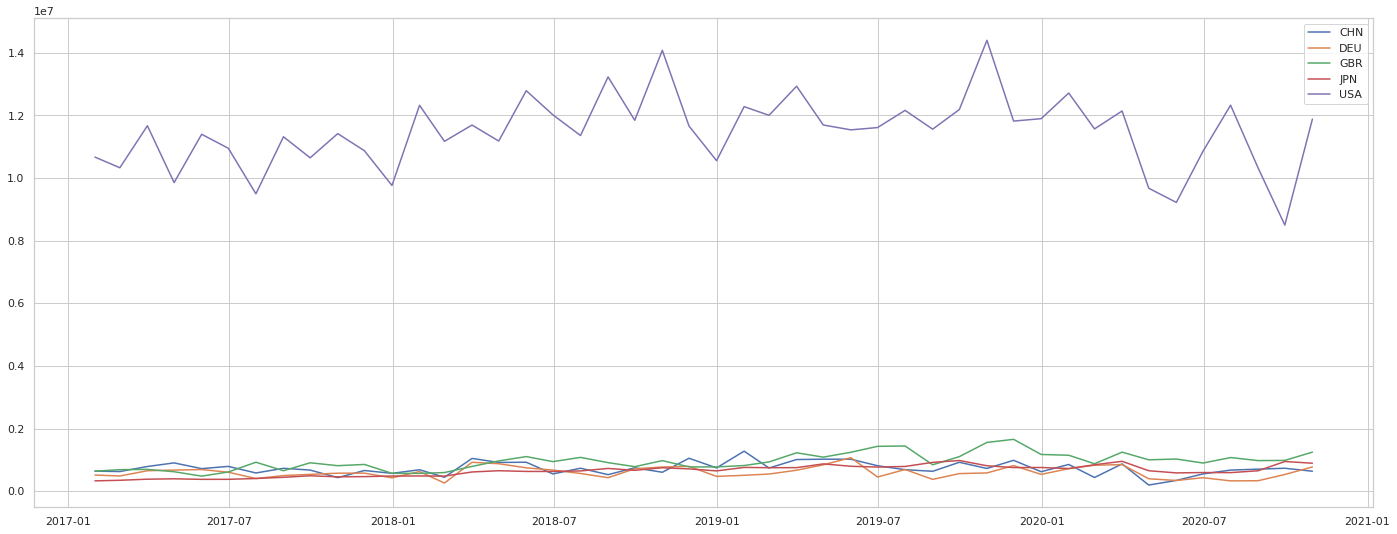

In [311]:
# plot the example time series
fig, ax = plt.subplots(figsize=(24,9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):    
    plt.plot(g[1][time_column_name].values, g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

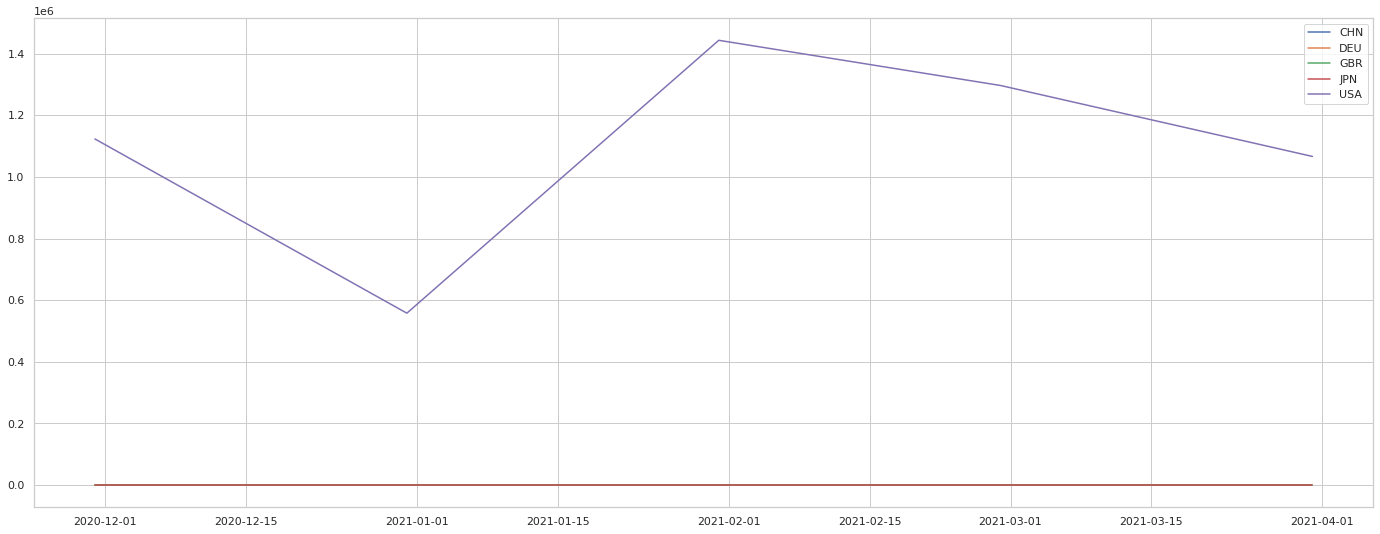

In [312]:
# plot the example time series
fig, ax = plt.subplots(figsize=(24,9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):    
    plt.plot(g[1][time_column_name].values, g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

In [313]:
datastore = ws.get_default_datastore()
datastore
datastore.upload_files(files = ['./revtime_train.csv', './revtime_test.csv'], target_path = 'merge_final/', overwrite = True,show_progress = True)

Uploading an estimated of 2 files
Uploading ./revtime_train.csv
Uploaded ./revtime_train.csv, 1 files out of an estimated total of 2
Uploading ./revtime_test.csv
Uploaded ./revtime_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_444e601fa55e490d9d8e6db6877d7833

In [314]:
#Create dataset for training
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('merge_final/revtime_train.csv'))

train_dataset.to_pandas_dataframe().tail()

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
225,2020-06-30,USA,10858122,21784901,9501417,-6,126521970,447,3100.290000,0,0,0,0,0,0,10858125,10858125,10858125,10858125,10858125,10858125,10830037,13201257,9929776,11906603,9424954,6057715,3658279,2638496,1295631,926419,809113,127796
226,2020-07-31,USA,12328340,16159400,11213216,-5,123012807,442,3271.120000,0,0,0,0,0,0,0,12328339,12328339,12328339,12328339,12328339,12088902,12184984,12418145,8775260,10623043,6908687,4471193,2509358,1991770,521975,598624,363744
227,2020-08-31,USA,10320678,33327484,7371988,-4,134992865,440,3500.310000,0,0,0,0,0,0,0,0,10320681,10320681,10320681,10320681,10432896,12071248,12171993,10612735,6776533,7441146,4931528,3212107,1413711,1221504,392297,495628
228,2020-09-30,USA,8500080,27473750,8118021,-3,94311290,450,3363.000000,0,0,0,0,0,0,0,0,0,8500081,8500081,8500081,8178169,9545902,10901885,9754667,8512563,6198031,6762805,3723652,2326824,1468976,1141987,364152
229,2020-10-31,USA,11883471,29088109,13538229,-2,98760974,442,3269.960000,0,0,0,0,0,0,0,0,0,0,11883473,11883473,12055958,12007490,11613032,9666353,8598510,8898996,6708893,6758509,2715520,2113287,1381738,1046873


In [315]:
#Modeling

In [316]:
#Featurization Customization examples
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return','sp500_1M_Previous']  
# Force the CPWVOL5 feature to be numeric type.
#featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.
featurization_config.add_transformer_params('Imputer', [target_column_name], {"strategy": "constant", "fill_value": 0})
# Fill missing values in the Current Opp Period Value column with median value.
featurization_config.add_transformer_params('Imputer', ['Current_Opp._Period_Value'], {"strategy": "median"})
featurization_config.add_transformer_params('Imputer', ['Conversions'], {"strategy": "median"})
# Fill missing values in the sp500 column with forward fill (last value carried forward).
featurization_config.add_transformer_params('Imputer', ['sp500'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount_Contingent'], {"strategy": "ffill"})

In [317]:
# Train
from azureml.automl.core.forecasting_parameters import ForecastingParameters
lags = 'auto'#[x for x in range(1,5)]
print('lags: ',lags)
window_size = 'auto'
forecast_horizon = n_test_periods
print('forecast_horizon: ',forecast_horizon)
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags,
    feature_lags = 'auto',
    target_rolling_window_size=window_size
)

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_revtime_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             experiment_timeout_hours=4,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             featurization='auto',#featurization_config,
                             n_cross_validations=5,
                             verbosity=logging.INFO,                             
                             max_concurrent_iterations=4,
                             max_cores_per_iteration=-1,
                             enable_dnn=True,
                             forecasting_parameters=forecasting_parameters)

lags:  auto
forecast_horizon:  6


In [318]:
#submit a new training run
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

Running on remote.
Running on remote compute: cibimldev01
Parent Run ID: AutoML_6ef11f94-9a8e-4679-9259-23dc57f5fe0f

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.
Heuristic parameters: Target_Lag = '[1]', Target_Rolling_Window = '11'.


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: 

Experiment,Id,Type,Status,Details Page,Docs Page
revenue-time-forecast,AutoML_6ef11f94-9a8e-4679-9259-23dc57f5fe0f,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [319]:
remote_run.wait_for_completion()

{'runId': 'AutoML_6ef11f94-9a8e-4679-9259-23dc57f5fe0f',
 'target': 'cibimldev01',
 'status': 'Completed',
 'startTimeUtc': '2020-12-01T16:46:15.175996Z',
 'endTimeUtc': '2020-12-01T16:59:54.583844Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'cibimldev01',
  'AMLSettingsJsonString': '{"path":null,"name":"revenue-time-forecast","subscription_id":"db61fd47-db56-45e3-844f-1b1f5c47990a","resource_group":"BI-DevQA-RG","workspace_name":"dwmlazwu01","region":"westus2","compute_target":"cibimldev01","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validat

In [320]:
#Retrieve the Best Model
best_run, fitted_model = remote_run.get_output()
print("Best Run Model: ", best_run)
print(fitted_model.steps)
model_name = best_run.properties['model_name']
print("Model Name: ", model_name)

Best Run Model:  Run(Experiment: revenue-time-forecast,
Id: AutoML_6ef11f94-9a8e-4679-9259-23dc57f5fe0f_510,
Type: azureml.scriptrun,
Status: Completed)
[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7fdbcdc90470>), ('DecisionTreeRegressor', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.006056302831963706,
                      min_samples_split=0.000630957344480193,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='random'))]
Model Name:  AutoML6ef11f949510


In [321]:
#Transparency
#View updated featurization summary
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,-10M Pipeline,Numeric,No,11,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
1,-11M Pipeline,Numeric,No,4,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag]"
2,-12M Pipeline,Numeric,No,8,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
3,-1M Pipeline,Numeric,No,16,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
4,-2M Pipeline,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,-3M Pipeline,Numeric,No,3,"[MedianImputer, ImputationMarker, MedianImputer-Lag]"
6,-4M Pipeline,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,-5M Pipeline,Numeric,No,7,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
8,-6M Pipeline,Numeric,No,3,"[MedianImputer, ImputationMarker, MedianImputer-Lag]"
9,-7M Pipeline,Numeric,No,3,"[MedianImputer, ImputationMarker, MedianImputer-Lag]"


In [322]:
#Explore the results
from azureml.widgets import RunDetails
RunDetails(best_run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [323]:
#FORECASTING
X_test = test
y_test = X_test.pop(target_column_name).values

In [324]:
X_test.tail()

,End_of_Month,Fin_Entity_ID,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline
234,2020-11-30,USA,9148002,7312301,-1,137182034,437,3621.630000,0,0,0,0,0,0,0,0,0,0,0,10309270,10309270,11334818,8899072,7197377,5629916,4400992,4897742,4087145,4087034,1756028,1486370,1018246
239,2020-12-31,USA,50000,785000,0,26591116,425,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,9916151,9921073,10215871,6436567,4639716,3635890,3645987,3544811,2967330,3303201,1424520,991851
244,2021-01-31,USA,0,0,1,0,422,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,11780511,11793783,8046008,5077523,2949627,2252736,1424696,1133635,922570,913153,248595
249,2021-02-28,USA,0,0,2,0,422,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7903088,7929256,5192342,3210069,1559962,1081944,969572,666242,636639,615544
254,2021-03-31,USA,0,0,3,0,421,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7569253,7574891,4850050,2844279,1523572,1057340,775068,685777,726170


In [325]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

In [326]:
#from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test)
df_all

,End_of_Month,Fin_Entity_ID,origin,predicted,horizon_origin,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline,Revenue
0,2020-11-30,CHN,2020-10-31,637368.000000,1,2288135,1264865,-1,10158254,33,3621.630000,0,0,0,0,0,0,0,0,0,0,0,772664,772664,1235091,1123457,643538,465681,219259,119989,76975,80460,405355,254256,191293,0
1,2020-12-31,CHN,2020-10-31,195142.000000,2,0,0,0,2037994,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,644620,644620,643539,818182,580025,382578,188985,58159,12658,0,375000,72873,0
2,2021-01-31,CHN,2020-10-31,195142.000000,3,0,0,1,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,730173,730173,483322,527130,409709,151518,32791,0,0,0,227268,0
3,2021-02-28,CHN,2020-10-31,195142.000000,4,0,0,2,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,635647,635647,336568,479593,419639,160720,86907,0,0,0,0
4,2021-03-31,CHN,2020-10-31,195142.000000,5,0,0,3,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623499,623499,246964,276270,319375,110004,99807,0,0,0
5,2020-11-30,DEU,2020-10-31,637368.000000,1,1560436,97350,-1,8978089,27,3621.630000,0,0,0,0,0,0,0,0,0,0,0,823226,823226,767040,800391,450504,482584,366715,254206,253834,86901,66733,56587,78143,0
6,2020-12-31,DEU,2020-10-31,195142.000000,2,0,0,0,1705216,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,593093,593093,553432,460008,268498,401431,268728,260087,214768,48548,49514,49514,0
7,2021-01-31,DEU,2020-10-31,195142.000000,3,0,0,1,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,507829,507829,418337,341186,90802,226715,91957,87906,64208,0,0,0
8,2021-02-28,DEU,2020-10-31,195142.000000,4,0,0,2,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,582877,582877,399180,299347,86478,191585,41652,28800,55026,0,0
9,2021-03-31,DEU,2020-10-31,195142.000000,5,0,0,3,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,369799,369799,264242,161432,99449,134500,24195,30220,63280,0


In [327]:
#Evaluate
#To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

#We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

#assign_dict = {'predicted': y_predictions, target_column_name: y_test}
#df_all = X_test.assign(**assign_dict)
#df_all

[Test data scores]

normalized_root_mean_squared_error:   1.000
r2_score:   -1.000
spearman_correlation:   0.806
median_absolute_error:   195142.000
normalized_mean_absolute_error:   1.000
mean_absolute_error:   2419420.749
root_mean_squared_error:   4832470.426
normalized_median_absolute_error:   0.135
mean_absolute_percentage_error:   1105.897
explained_variance:   -82.028
root_mean_squared_log_error:   11.216
normalized_root_mean_squared_log_error:   0.791


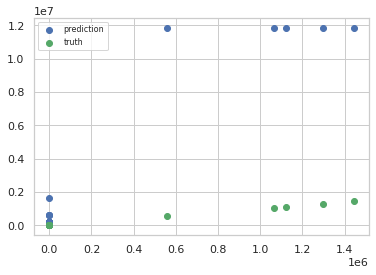

In [328]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [329]:
#Confidence intervals
quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

,End_of_Month,Fin_Entity_ID,0.5
0,2020-11-30,CHN,637368.000000
1,2020-12-31,CHN,195142.000000
2,2021-01-31,CHN,195142.000000
3,2021-02-28,CHN,195142.000000
4,2021-03-31,CHN,195142.000000
5,2020-11-30,DEU,637368.000000
6,2020-12-31,DEU,195142.000000
7,2021-01-31,DEU,195142.000000
8,2021-02-28,DEU,195142.000000
9,2021-03-31,DEU,195142.000000


In [330]:
# specify which quantiles you would like 
fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]
# use forecast_quantiles function, not the forecast() one
y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 
y_pred_quantiles

,End_of_Month,Fin_Entity_ID,0.01,0.5,0.8,0.95
0,2020-11-30,CHN,104512.773295,637368.000000,830143.241493,1014125.432569
1,2020-12-31,CHN,-823326.507749,195142.000000,563601.391397,915254.257328
2,2021-01-31,CHN,-1413332.758589,195142.000000,777052.610017,1332420.551522
3,2021-02-28,CHN,-952255.551852,195142.000000,610245.069392,1006414.056849
4,2021-03-31,CHN,-1032296.480788,195142.000000,639202.108062,1063007.317785
5,2020-11-30,DEU,104512.773295,637368.000000,830143.241493,1014125.432569
6,2020-12-31,DEU,-823326.507749,195142.000000,563601.391397,915254.257328
7,2021-01-31,DEU,-1413332.758589,195142.000000,777052.610017,1332420.551522
8,2021-02-28,DEU,-952255.551852,195142.000000,610245.069392,1006414.056849
9,2021-03-31,DEU,-1032296.480788,195142.000000,639202.108062,1063007.317785


In [331]:
#Get the column index list in the right order
cols_sort_list = list(df_all.columns) + ['Revenue_Forecast']
display(cols_sort_list)
display(df_all)

['End_of_Month',
 'Fin_Entity_ID',
 'origin',
 'predicted',
 'horizon_origin',
 'Current_Opp._Period_Value',
 'Conversions',
 'Relative_Month_Offset',
 'Pipeline_Trend',
 'Total_Headcount',
 'sp500',
 '-12M Pipeline',
 '-11M Pipeline',
 '-10M Pipeline',
 '-9M Pipeline',
 '-8M Pipeline',
 '-7M Pipeline',
 '-6M Pipeline',
 '-5M Pipeline',
 '-4M Pipeline',
 '-3M Pipeline',
 '-2M Pipeline',
 '-1M Pipeline',
 '0M Pipeline',
 '1M Pipeline',
 '2M Pipeline',
 '3M Pipeline',
 '4M Pipeline',
 '5M Pipeline',
 '6M Pipeline',
 '7M Pipeline',
 '8M Pipeline',
 '9M Pipeline',
 '10M Pipeline',
 '11M Pipeline',
 'Revenue',
 'Revenue_Forecast']

,End_of_Month,Fin_Entity_ID,origin,predicted,horizon_origin,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline,Revenue
0,2020-11-30,CHN,2020-10-31,637368.000000,1,2288135,1264865,-1,10158254,33,3621.630000,0,0,0,0,0,0,0,0,0,0,0,772664,772664,1235091,1123457,643538,465681,219259,119989,76975,80460,405355,254256,191293,0
1,2020-12-31,CHN,2020-10-31,195142.000000,2,0,0,0,2037994,33,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,644620,644620,643539,818182,580025,382578,188985,58159,12658,0,375000,72873,0
2,2021-01-31,CHN,2020-10-31,195142.000000,3,0,0,1,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,730173,730173,483322,527130,409709,151518,32791,0,0,0,227268,0
3,2021-02-28,CHN,2020-10-31,195142.000000,4,0,0,2,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,635647,635647,336568,479593,419639,160720,86907,0,0,0,0
4,2021-03-31,CHN,2020-10-31,195142.000000,5,0,0,3,0,32,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623499,623499,246964,276270,319375,110004,99807,0,0,0
5,2020-11-30,DEU,2020-10-31,637368.000000,1,1560436,97350,-1,8978089,27,3621.630000,0,0,0,0,0,0,0,0,0,0,0,823226,823226,767040,800391,450504,482584,366715,254206,253834,86901,66733,56587,78143,0
6,2020-12-31,DEU,2020-10-31,195142.000000,2,0,0,0,1705216,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,593093,593093,553432,460008,268498,401431,268728,260087,214768,48548,49514,49514,0
7,2021-01-31,DEU,2020-10-31,195142.000000,3,0,0,1,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,507829,507829,418337,341186,90802,226715,91957,87906,64208,0,0,0
8,2021-02-28,DEU,2020-10-31,195142.000000,4,0,0,2,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,582877,582877,399180,299347,86478,191585,41652,28800,55026,0,0
9,2021-03-31,DEU,2020-10-31,195142.000000,5,0,0,3,0,26,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,369799,369799,264242,161432,99449,134500,24195,30220,63280,0


In [332]:
#Merge df_all with train
from functools import reduce
nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True).sort_values(by=sort_list)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
#final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
#create new column
final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted']!=0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = round((final_merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
final_merge_df['End_of_Month'] = pd.to_datetime(final_merge_df['End_of_Month']).dt.date
final_merge_df['origin'] = pd.to_datetime(final_merge_df['origin']).dt.date
#inal_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short'])
final_merge_df = final_merge_df.sort_values(by=sort_list).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list) #sort using original cols_sort_list
print("\n final_merge_df: \n")
final_merge_df.to_csv("final_merge_df.csv", index=False)
show_stats(merge_df)
final_merge_df.query('Fin_Entity_ID==@entity_debug')


 final_merge_df: 


 DF Name: 



'merge_df'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 10 columns):
End_of_Month                 295 non-null datetime64[ns]
Fin_Entity_ID                295 non-null object
Revenue                      295 non-null int64
Headcount                    295 non-null int64
Headcount_Contingent         295 non-null int64
Current_Opp._Period_Value    295 non-null int64
Conversions                  295 non-null int64
Relative_Month_Offset        295 non-null int64
Pipeline_Trend               295 non-null int64
Total_Headcount              295 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 25.4+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,295,59,2017-11-30 00:00:00,5,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,295,5,GBR,59,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,295.000000,NaN,NaN,NaN,NaT,NaT,2263840.403390,4006370.097060,0.000000,399981.000000,686520.000000,993530.000000,14401673.000000
Headcount,295.000000,NaN,NaN,NaN,NaT,NaT,105.908475,153.607687,18.000000,25.000000,30.000000,42.000000,429.000000
Headcount_Contingent,295.000000,NaN,NaN,NaN,NaT,NaT,7.664407,12.889084,0.000000,1.000000,3.000000,5.000000,61.000000



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
0,2017-01-31,CHN,639967,26,0,0,434540,-47,0,26
1,2017-01-31,DEU,515289,24,1,0,9959,-47,0,25
2,2017-01-31,GBR,640653,27,3,0,912449,-47,0,30
3,2017-01-31,JPN,329393,18,0,0,0,-47,0,18
4,2017-01-31,USA,10671035,390,23,0,12148741,-47,0,413



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
290,2021-11-30,CHN,0,28,4,0,0,11,0,32
291,2021-11-30,DEU,0,25,1,0,0,11,0,26
292,2021-11-30,GBR,0,42,4,0,0,11,0,46
293,2021-11-30,JPN,0,33,0,0,0,11,0,33
294,2021-11-30,USA,0,406,13,0,0,11,0,419



 Entity Sum: 



,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
0,CHN,33541483,1593,130,62534126,32085031,-1062,251391177,1723
1,DEU,27676819,1510,129,61537484,22175585,-1062,220879033,1639
2,GBR,43715091,2194,200,78564737,18725874,-1062,386783987,2394
3,JPN,29740004,1624,8,63710475,23290937,-1062,253724511,1632
4,USA,533159522,24322,1794,940718495,477837917,-1062,4256497673,26116



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
0,CHN,59,59,59,59,59,59,59,59,59
1,DEU,59,59,59,59,59,59,59,59,59
2,GBR,59,59,59,59,59,59,59,59,59
3,JPN,59,59,59,59,59,59,59,59,59
4,USA,59,59,59,59,59,59,59,59,59



 EOM Sum:


,End_of_Month,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
0,2017-01-31,12796337,485,27,0,13505689,-235,0,512
1,2017-02-28,12476757,485,26,0,8659142,-230,0,511
2,2017-03-31,14191127,487,26,0,12745280,-225,0,513
3,2017-04-30,12449452,484,24,0,10701239,-220,0,508
4,2017-05-31,13669410,491,23,0,6457961,-215,0,514



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
0,2017-01-31,5,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5,5


,End_of_Month,Fin_Entity_ID,origin,predicted,horizon_origin,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-12M Pipeline,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline,11M Pipeline,Revenue,Revenue_Forecast
2,2017-01-31,GBR,1970-01-01,0,0,0,912449,-47,0,30,2278.870000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,640653,640653
7,2017-02-28,GBR,1970-01-01,0,0,0,293644,-46,0,31,2363.640000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,686520,686520
12,2017-03-31,GBR,1970-01-01,0,0,0,484583,-45,0,29,2362.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,695914,695914
17,2017-04-30,GBR,1970-01-01,0,0,0,0,-44,0,29,2384.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,620690,620690
22,2017-05-31,GBR,1970-01-01,0,0,0,255102,-43,0,30,2411.800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,480997,480997
27,2017-06-30,GBR,1970-01-01,0,0,0,958208,-42,0,31,2423.410000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,613119,613119
32,2017-07-31,GBR,1970-01-01,0,0,0,4920,-41,0,32,2470.300000,924330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,924330,924330
37,2017-08-31,GBR,1970-01-01,0,0,0,1677150,-40,0,31,2471.650000,652908,652908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,652908,652908
42,2017-09-30,GBR,1970-01-01,0,0,0,322465,-39,0,31,2519.360000,906711,906711,906711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,906711,906711
47,2017-10-31,GBR,1970-01-01,0,0,0,367121,-38,0,30,2575.260000,813818,813818,813818,813818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,813818,813818


In [333]:
#pivot by EOM1, Fin_Entity_ID
final_merge_pivot1 = final_merge_df.pivot_table(index=['End_of_Month','Relative_Month_Offset'], 
                                                columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=True)
final_merge_pivot1 = final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)
#final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
#show_stats(revtime_pivot1)
final_merge_pivot1#.query('(End_of_Month == @current_eom)')

Fin_Entity_ID,End_of_Month,Relative_Month_Offset,CHN,DEU,GBR,JPN,USA,All
0,2017-01-31,-47,639967,515289,640653,329393,10671035,12796337
1,2017-02-28,-46,626792,484995,686520,347933,10330517,12476757
2,2017-03-31,-45,787987,652723,695914,382427,11672076,14191127
3,2017-04-30,-44,903022,674009,620690,395162,9856569,12449452
4,2017-05-31,-43,719566,690926,480997,377712,11400209,13669410
5,2017-06-30,-42,791621,604594,613119,378366,10952349,13340049
6,2017-07-31,-41,581189,403545,924330,405259,9498045,11812368
7,2017-08-31,-40,730547,497959,652908,442962,11320436,13644812
8,2017-09-30,-39,673848,536501,906711,491872,10648117,13257049
9,2017-10-31,-38,432792,574534,813818,458260,11420726,13700130


In [334]:
# multiple line plot
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("poster") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
#sns.palplot(palette)
# Set the palette using the name of a palette:
#sns.set_palette(palette)

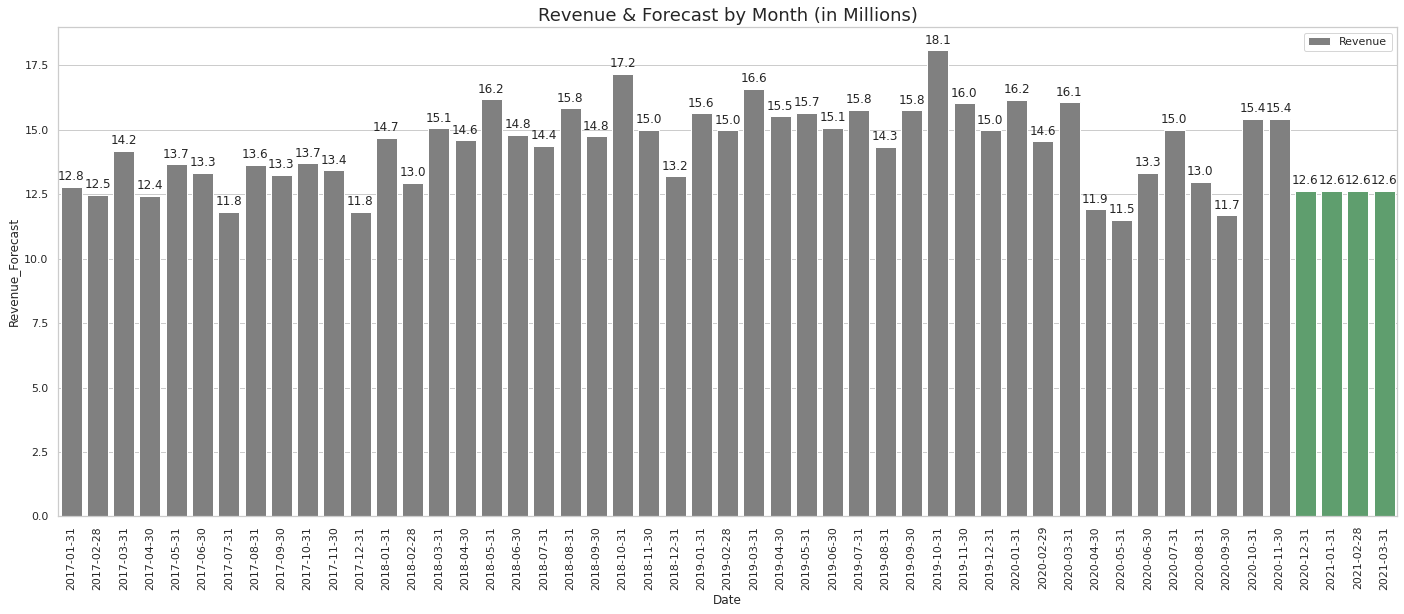

In [335]:
#Bar plot for history and forecast revenues summary by month
fig, ax = plt.subplots(figsize=(24,9))
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 =final_merge_df.pivot_table(index=['End_of_Month','Relative_Month_Offset'], 
                                                #columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=False)
final_merge_df1 = final_merge_df1.reset_index(level=final_merge_df1.index.names)
final_merge_df1['Date'] = pd.to_datetime(final_merge_df1['End_of_Month']).dt.date#.astype(str)
final_merge_df1['Revenue_Forecast'] = round(final_merge_df1['Revenue_Forecast']/div_by_mil,4)
values = final_merge_df1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
#revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)
g = sns.barplot(x="Date", y="Revenue_Forecast", ci=None,
                data=final_merge_df1,
                palette=clrs, #alpha=0.50,
                ax=ax
               )
plt.xticks(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.legend(['Revenue','Forecast'], facecolor='w')
plt.show()

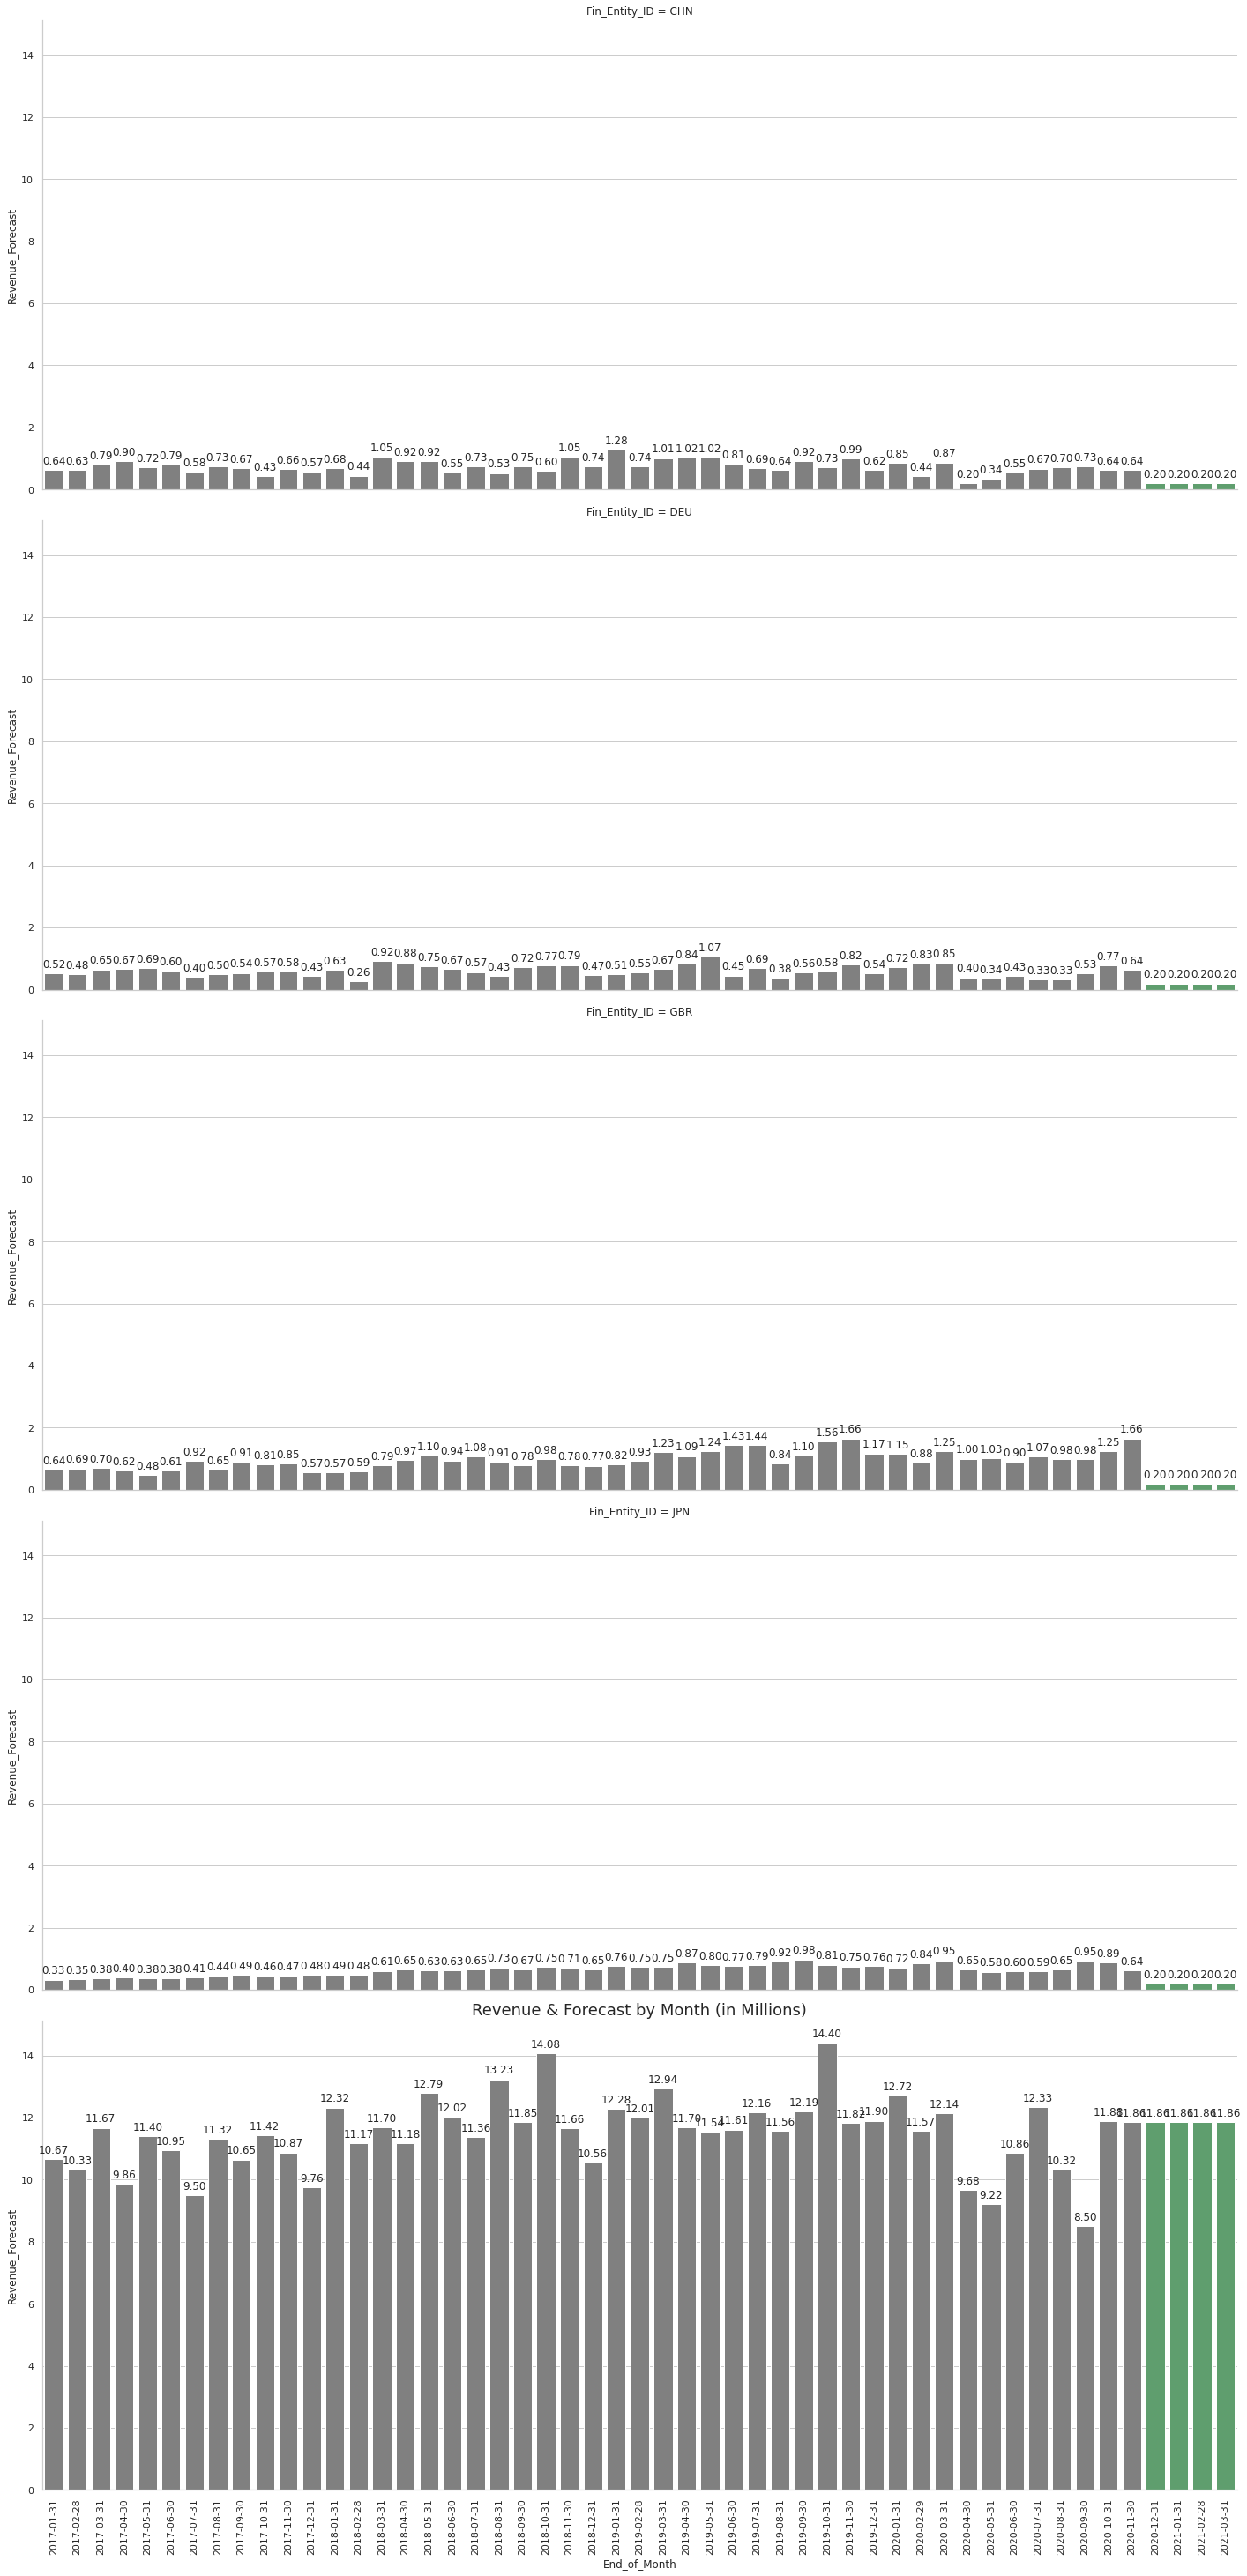

In [336]:
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 = final_merge_df.copy()
final_merge_df1['Revenue_Forecast'] = round(final_merge_df1['Revenue_Forecast']/div_by_mil,4)
values = final_merge_df1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
g = sns.FacetGrid(data=final_merge_df1,
                  col="Fin_Entity_ID",
                  height=8,
                  aspect=2.5,
                  col_wrap=1
                  #palette=clrs, #alpha=0.50
               )
g.map_dataframe(sns.barplot, "End_of_Month", "Revenue_Forecast", palette=clrs)
for ax in g.axes.ravel():
  for p in ax.patches:
    ax.annotate("{:,.2f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.set_xticklabels(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
plt.show()

In [285]:
STOP*************************************************************

SyntaxError: invalid syntax (<ipython-input-285-212ce48f0d87>, line 1)

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting revenue service")

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv("revtime_hist.csv", index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv("revtime_foreast.csv", index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context("talk") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()